In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/ML/projects/natural-gas/

/content/drive/MyDrive/Colab Notebooks/ML/projects/natural-gas


# **Loading data**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
df=pd.read_csv('processed_nasdaq.csv', index_col="Date", parse_dates=True)
df = df.drop(["vol"], axis=1)
seasons = {"Spring": 1,
           "Summer": 2,
           "Autumn": 3,
           "Winter": 4}
df["season"] = df.season.map(seasons)
df = df[::-1]
df.head(10)

,close,open,high,low,season
Date,,,,,
2012-05-02,2.253,2.371,2.384,2.236,1
2012-05-03,2.340,2.260,2.379,2.253,1
2012-05-04,2.279,2.340,2.373,2.265,1
2012-05-07,2.336,2.277,2.358,2.273,1
2012-05-08,2.393,2.323,2.460,2.280,1
2012-05-09,2.465,2.440,2.509,2.403,1
2012-05-10,2.487,2.463,2.519,2.407,1
2012-05-11,2.509,2.467,2.529,2.456,1
2012-05-14,2.431,2.502,2.517,2.414,1


In [5]:
df.head(100)

,close,open,high,low,season
Date,,,,,
2012-05-02,2.253,2.371,2.384,2.236,1
2012-05-03,2.340,2.260,2.379,2.253,1
2012-05-04,2.279,2.340,2.373,2.265,1
2012-05-07,2.336,2.277,2.358,2.273,1
2012-05-08,2.393,2.323,2.460,2.280,1
...,...,...,...,...,...
2012-09-12,3.063,3.001,3.068,2.950,3
2012-09-13,3.037,3.063,3.070,2.960,3
2012-09-14,2.943,3.036,3.062,2.920,3


In [6]:
df.isnull().sum()

close     0
open      0
high      0
low       0
season    0
dtype: int64

# **Visualizing Data**

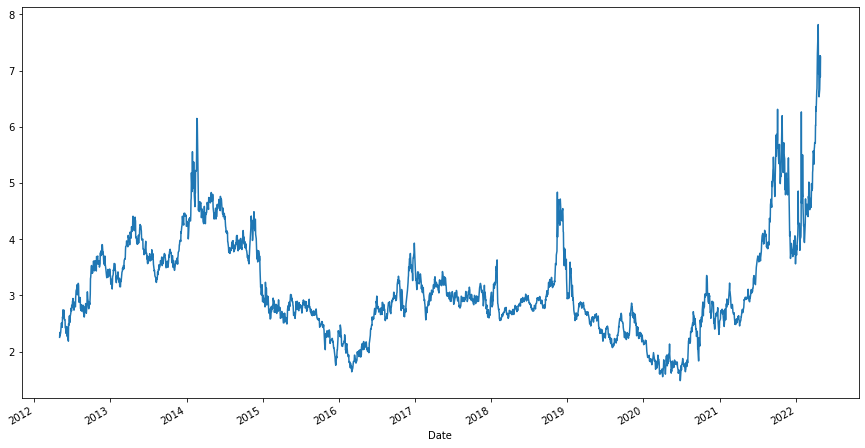

In [7]:
df.close.plot(figsize=(15, 8))

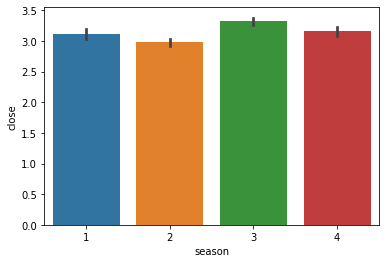

In [8]:
sns.barplot(x=df.season, y=df.close)

# **Testing for stationarity**

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
test_result = adfuller(df.close)
test_result

(-1.1254284083043977,
 0.7048255697947898,
 23,
 2527,
 {'1%': -3.4329404056582598,
  '5%': -2.862684432835292,
  '10%': -2.567379225007826},
 -3520.3710788389735)

In [11]:
#Ho: It is not stationary
#H1: It is stationary

def adfuller_test(price):
    result = adfuller(price)
    labels = ["ADF Test statistic", "pi value", "#Lags used", "Number of observations used"]
    for value, label in zip(result, labels):
        print(label+ " : " + str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

In [12]:
adfuller_test(df.close)

ADF Test statistic : -1.1254284083043977
pi value : 0.7048255697947898
#Lags used : 23
Number of observations used : 2527
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


# **Differencing**

In [13]:
df["close_first_difference"] = df["close"] - df["close"].shift(1)

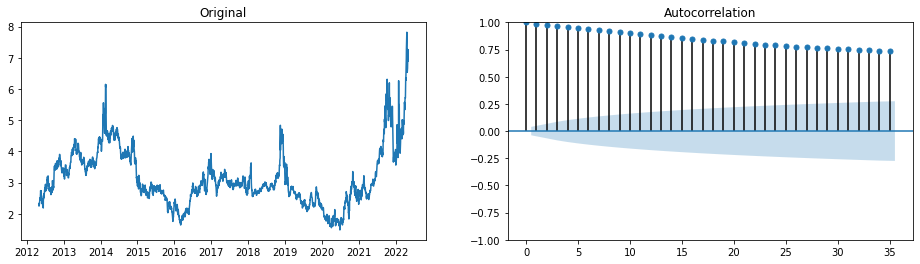

In [14]:
# autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(df.close)
ax1.set_title("Original")
plot_acf(df.close, ax=ax2);

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


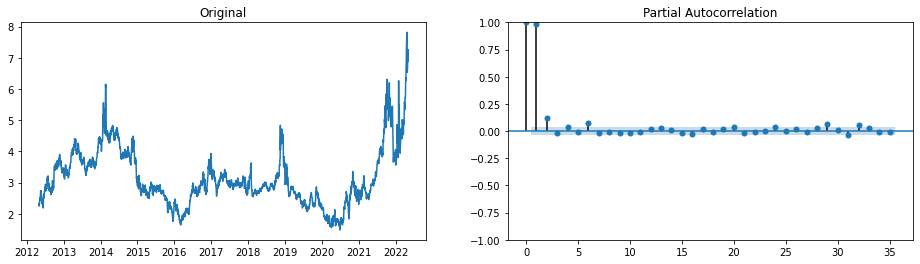

In [15]:
# autocorrelation function
from statsmodels.graphics.tsaplots import plot_pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(df.close)
ax1.set_title("Original")
plot_pacf(df.close, ax=ax2);

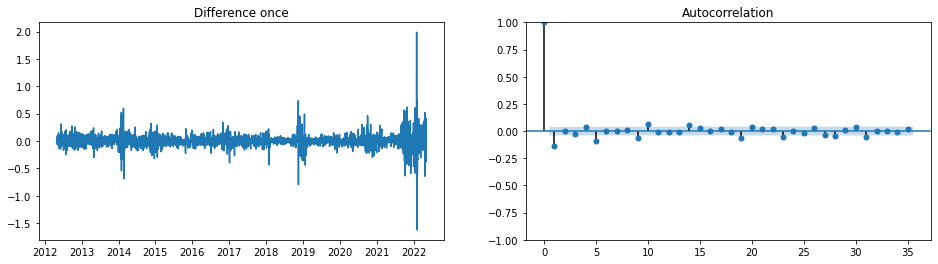

In [16]:
diff = df.close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


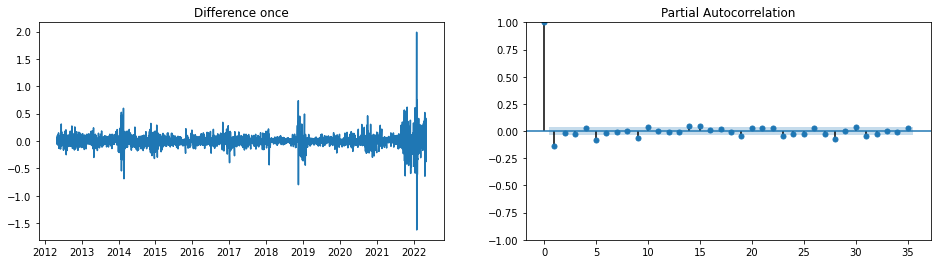

In [17]:
diff = df.close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
plot_pacf(diff, ax=ax2);

**we can also use the pmdarima package to get the number of differencing**

In [18]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Finding the value for d using pmdarima**

In [19]:
from pmdarima.arima.utils import ndiffs
ndiffs(df.close, test="adf")

1

So we got the d value, 

# **now we have to choose our p value**

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


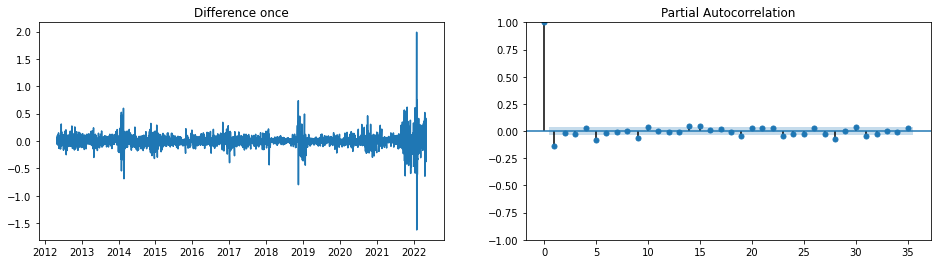

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
diff = df.close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

The 4th point is slightly above the line, so set p=4

# **Now we have to find the value for q**

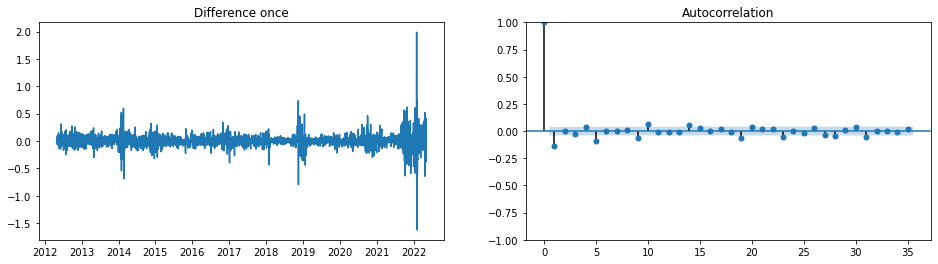

In [21]:
diff = df.close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

Again the 4th point is slightly above the line, so set q=4

# **Final ARIMA**

In [22]:
adfuller_test(df.close_first_difference.dropna())

ADF Test statistic : -10.159599979846758
pi value : 7.569132503743969e-18
#Lags used : 27
Number of observations used : 2522
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


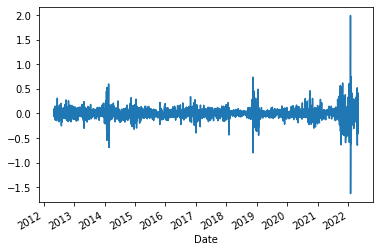

In [23]:
df.close_first_difference.plot()

In [24]:
x = df.close.dropna()

In [25]:
# for non-seasonal data
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [26]:
model = sm.tsa.arima.ARIMA(x, order=(4, 1, 4))
model_fit = model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
df.shape

(2551, 6)

In [28]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2551
Model:                 ARIMA(4, 1, 4)   Log Likelihood                1795.523
Date:                Fri, 13 Jan 2023   AIC                          -3573.047
Time:                        11:14:10   BIC                          -3520.452
Sample:                             0   HQIC                         -3553.971
                               - 2551                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4920      0.098     -5.010      0.000      -0.684      -0.300
ar.L2         -0.3526      0.098     -3.593      0.000      -0.545      -0.160
ar.L3          0.0115      0.103      0.112      0.911      -0.190       0.213
ar.L4          0.5938      0.058     10.253      0.000       0.480       0.707
ma.L1          0.3586      0.099      3.622      0.000       0.165       0.553
ma.L2          0.2800      0.086      3.271      0.001       0.112       0.448
ma.L3         -0.0874      0.092     -0.953      0.341      -0.267       0.092
ma.L4         -0.5906      0.049    -11.981      0.000      -0.687      -0.494
sigma2         0.0143      0.000    120.471      0.000       0.014       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            158656.46
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
df.shape

(2551, 6)

In [30]:
2551 - 2551*0.2

2040.8

In [31]:
start = 2041
end = 2550

In [32]:
df.close[2041:]

Date
2020-04-23    1.815
2020-04-24    1.746
2020-04-27    1.819
2020-04-28    1.794
2020-04-29    1.869
              ...  
2022-04-25    6.669
2022-04-26    6.850
2022-04-27    7.267
2022-04-28    6.888
2022-04-29    7.244
Name: close, Length: 510, dtype: float64

In [33]:
forecast = model_fit.predict(start=start, end=end, dynamic=False)
df["forecast"] = forecast

In [34]:
forecast.shape

(510,)

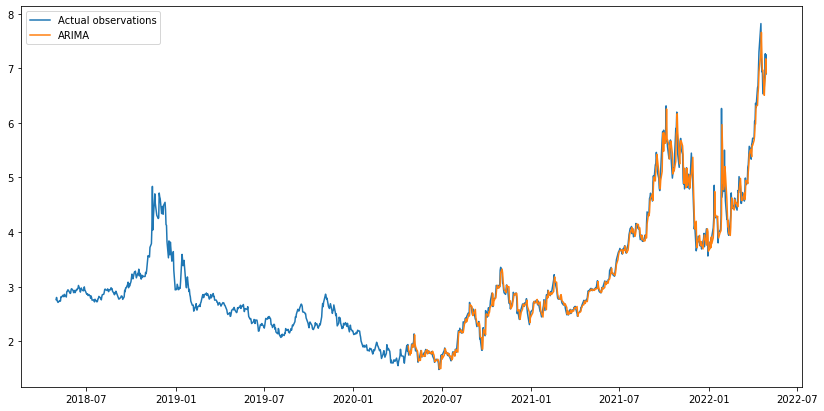

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(df.close[start-500:], label="Actual observations")
plt.plot(df.forecast, label="ARIMA")
plt.legend()
plt.show()

# **Accuracy**

In [36]:
from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(df.iloc[start:, 0], df.iloc[start:, 6])
R2 = r2_score(df.iloc[start:, 0], df.iloc[start:, 6])
RMSE = sqrt(mean_squared_error(df.iloc[start:, 0], df.iloc[start:, 6]))
MAE = mean_absolute_error(df.iloc[start:, 0], df.iloc[start:, 6])
MAPE = mean_absolute_percentage_error(df.iloc[start:, 0], df.iloc[start:, 6]) 


from tabulate import tabulate
results= [["ARIMA with NASDAQ",MSE,R2,RMSE,MAE,MAPE]]
col_names = ["Model/Metrics", "MSE","R-Squared","RMSE","MAE","MAPE"]
print(tabulate(results,headers=col_names,tablefmt="fancy_grid"))

╒═══════════════════╤══════════╤═════════════╤══════════╤══════════╤═════════╕
│ Model/Metrics     │      MSE │   R-Squared │     RMSE │      MAE │    MAPE │
╞═══════════════════╪══════════╪═════════════╪══════════╪══════════╪═════════╡
│ ARIMA with NASDAQ │ 0.036708 │     0.97903 │ 0.191593 │ 0.115319 │ 0.03143 │
╘═══════════════════╧══════════╧═════════════╧══════════╧══════════╧═════════╛
